In [1]:
import torch
import tqdm
import torch.nn.functional as F
from torch import optim

from einops import rearrange

from astropy.visualization import make_lupton_rgb

from hydra import initialize, compose
from hydra.utils import instantiate
from pytorch_lightning.utilities import move_data_to_device

import matplotlib.pyplot as plt

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from bliss.encoder.metrics import CatalogMatcher
from bliss.global_env import GlobalEnv

from case_studies.dc2_new_diffusion.utils.autoencoder import CatalogEncoder, CatalogDecoder
from case_studies.dc2_new_diffusion.utils.metrics import DetectionPerformance
from case_studies.dc2_new_diffusion.utils.catalog_parser import CatalogParser

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
with initialize(config_path="./latent_diffusion_config", version_base=None):
    new_diffusion_notebook_cfg = compose("latent_diffusion_notebook_config")

In [3]:
tile_slen = new_diffusion_notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = new_diffusion_notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = new_diffusion_notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(new_diffusion_notebook_cfg.surveys.dc2)
dc2.batch_size = 512
dc2.setup(stage="fit")
GlobalEnv.current_encoder_epoch = 1
GlobalEnv.seed_in_this_program = 7272
dc2_train_dataloader = dc2.train_dataloader()

catalog_parser: CatalogParser = instantiate(new_diffusion_notebook_cfg.encoder.catalog_parser)

In [4]:
target_ch = catalog_parser.n_params_per_source
encoder = CatalogEncoder(target_ch, hidden_dim=32)
decoder = CatalogDecoder(target_ch, hidden_dim=32 // 4)

In [5]:
encoder = encoder.to(device=device)
decoder = decoder.to(device=device)

### Train encoder and decoder with image weights

In [6]:
def generate_mask_by_bbox_hw(tile_cat: TileCatalog):
    image_size = 80
    full_cat = tile_cat.to_full_catalog(tile_slen=4)
    on_mask = full_cat.is_on_mask  # (b, m)
    device = on_mask.device
    bbox_h = full_cat["bbox_hw"][..., -1].nan_to_num(0.0).unsqueeze(-1)  # (b, m, 1)
    bbox_h = bbox_h.clamp(min=5.0) * on_mask.unsqueeze(-1)  # (b, m, 1)
    plocs = full_cat["plocs"]  # (b, m, 2)
    bbox_yxr = torch.cat([plocs, bbox_h], dim=-1)  # (b, m, 3)

    sx = torch.arange(end=image_size, device=device) + 0.5
    sy = torch.arange(end=image_size, device=device) + 0.5
    sy, sx = torch.meshgrid(sy, sx, indexing="ij")
    anchor_yx = torch.stack((sy, sx), dim=-1).view(-1, 2)  # (80 * 80, 2)

    source_anchor_dist = ((rearrange(bbox_yxr[..., :-1], "b m k -> b m 1 k") - \
                           rearrange(anchor_yx, "anchor_points k -> 1 1 anchor_points k")) ** 2).sum(dim=-1).sqrt()  # (b, m, a)
    source_anchor_mask = (source_anchor_dist <= bbox_yxr[..., -1].unsqueeze(-1)) & on_mask.unsqueeze(-1)  # (b, m, a)
    anchor_mask = source_anchor_mask.any(dim=1)  # (b, a)
    return anchor_mask.view(anchor_mask.shape[0], image_size, image_size)  # (b, 80, 80)

In [7]:
def create_rgb(image, bgr=[1, 2, 3], stretch=0.5, Q=2, scale=None):
    if scale is None:
        r_im = image[bgr[2]]  # for the r channel
        g_im = image[bgr[1]]  # for the g channel
        b_im = image[bgr[0]]  # for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]] * scale[0]
        g_im = image[bgr[1]] * scale[1]
        b_im = image[bgr[0]] * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [8]:
one_sample = next(iter(dc2.train_dataloader()))
sample_image = one_sample["images"]
sample_tile_cat = TileCatalog(one_sample["tile_catalog"])

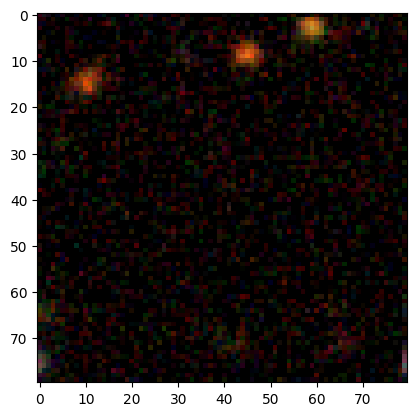

In [9]:
plt.imshow(create_rgb(sample_image[0]))
plt.show()

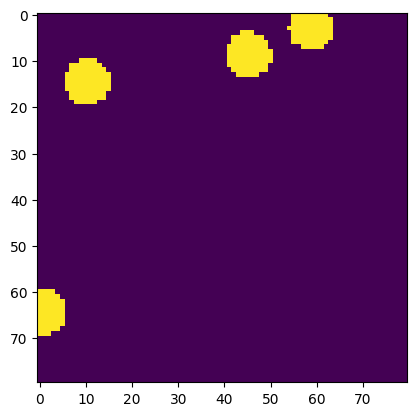

In [10]:
image_mask = generate_mask_by_bbox_hw(sample_tile_cat)
plt.imshow(image_mask[0])
plt.show()

In [11]:
def normal_distribution_penalty(output: torch.Tensor, target_mean=0.5, target_std=0.25):
    output_mean, output_std = output.mean(dim=(-1, -2, -3)), output.std(dim=(-1, -2, -3))
    target_distribution = torch.distributions.Normal(torch.full_like(output_mean, target_mean), 
                                                     torch.full_like(output_std, target_std))
    output_distribution = torch.distributions.Normal(output_mean, output_std)
    kl_div = torch.distributions.kl.kl_divergence(output_distribution, target_distribution)
    return kl_div.mean()

In [12]:
def smooth_loss_func(output: torch.Tensor):
    assert len(output.shape) == 4
    max_v = F.max_pool2d(output, kernel_size=4)
    min_v = F.max_pool2d(-output, kernel_size=4).abs()
    return (max_v - min_v).mean()

In [13]:
lr = 1e-2
optimizer = optim.Adam(list(encoder.parameters()) + \
                       list(decoder.parameters()), lr=lr, amsgrad=True)
# print(f"T max: {len(dc2_train_dataloader)}")
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, ], gamma=0.1)

[Epoch: 0]


 26%|██▌       | 99/381 [00:42<01:34,  3.00it/s]

step [100/381], total loss: 7.647e-03, mse loss: 7.565e-03, normal loss: 7.445e-05, smooth loss: 7.896e-06


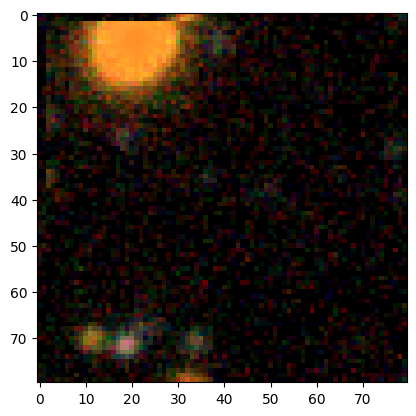

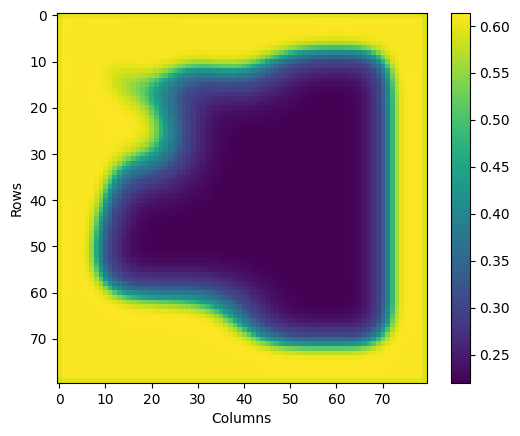

 52%|█████▏    | 199/381 [01:16<01:00,  3.03it/s]

step [200/381], total loss: 1.746e-03, mse loss: 1.625e-03, normal loss: 1.127e-04, smooth loss: 8.438e-06


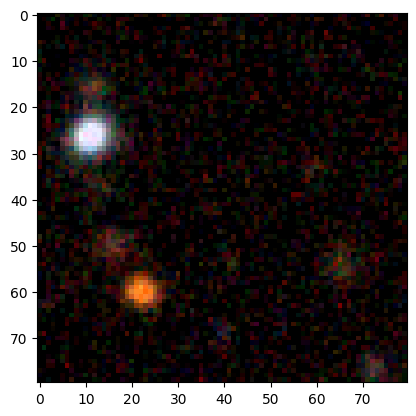

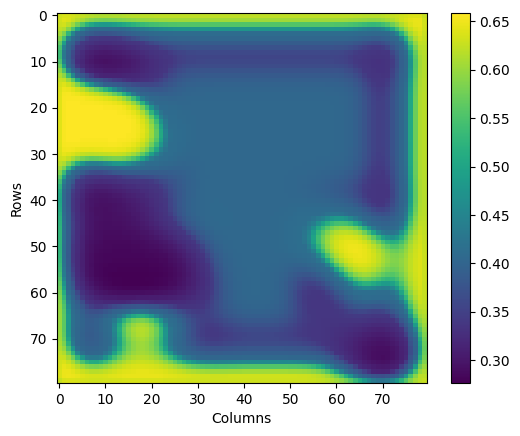

 78%|███████▊  | 299/381 [01:56<00:29,  2.75it/s]

step [300/381], total loss: 1.169e-03, mse loss: 1.078e-03, normal loss: 8.268e-05, smooth loss: 8.207e-06


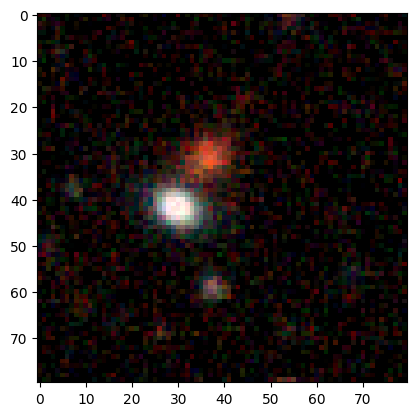

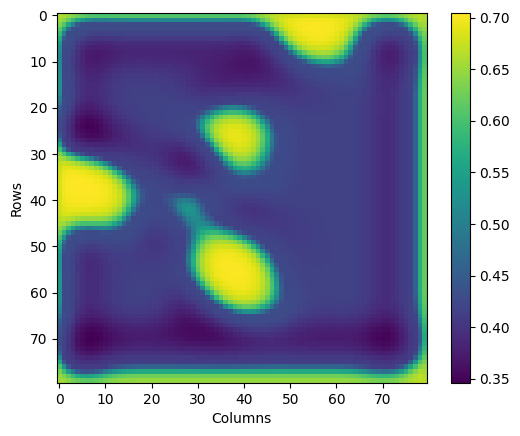

100%|██████████| 381/381 [02:24<00:00,  2.64it/s]


[Epoch: 1]


 26%|██▌       | 99/381 [00:41<01:44,  2.69it/s]

step [100/381], total loss: 7.445e-04, mse loss: 6.788e-04, normal loss: 5.815e-05, smooth loss: 7.521e-06


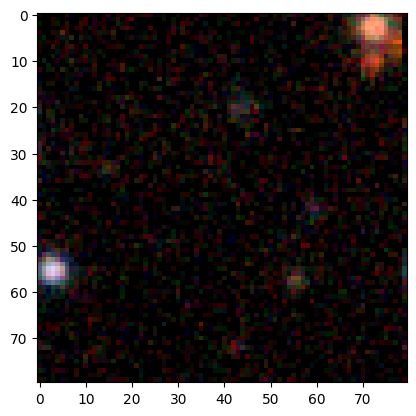

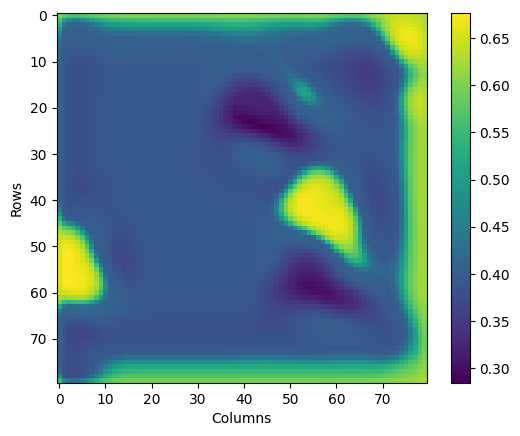

 52%|█████▏    | 199/381 [01:17<01:16,  2.38it/s]

step [200/381], total loss: 7.350e-04, mse loss: 6.889e-04, normal loss: 3.777e-05, smooth loss: 8.302e-06


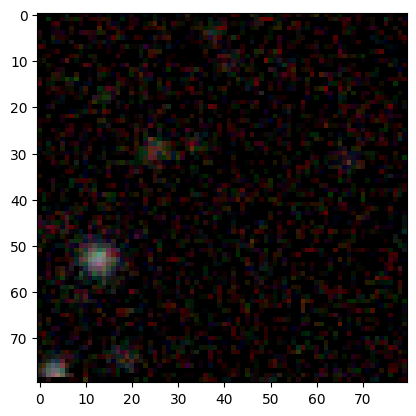

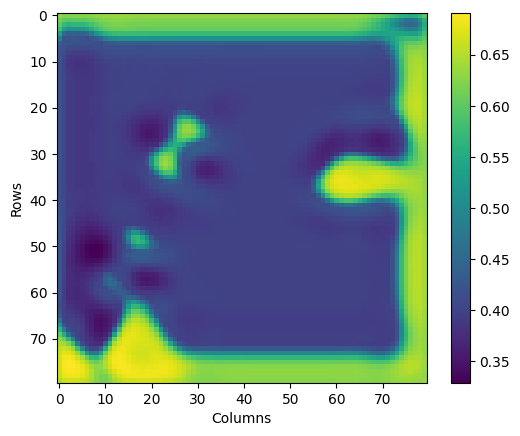

 78%|███████▊  | 299/381 [01:52<00:27,  2.96it/s]

step [300/381], total loss: 5.814e-04, mse loss: 5.381e-04, normal loss: 3.420e-05, smooth loss: 9.156e-06


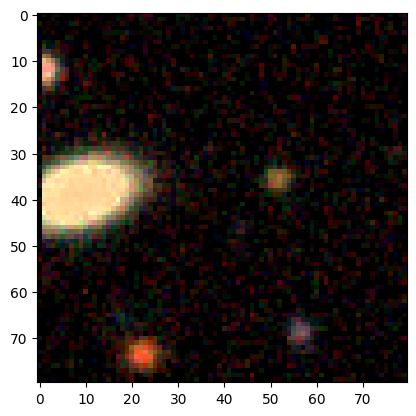

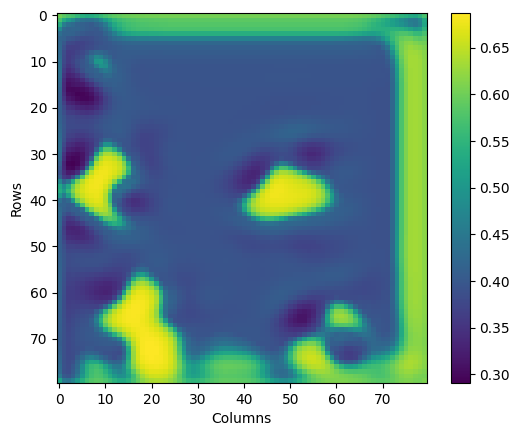

100%|██████████| 381/381 [02:24<00:00,  2.64it/s]


[Epoch: 2]


 26%|██▌       | 99/381 [00:42<01:31,  3.07it/s]

step [100/381], total loss: 3.917e-04, mse loss: 3.644e-04, normal loss: 1.823e-05, smooth loss: 9.080e-06


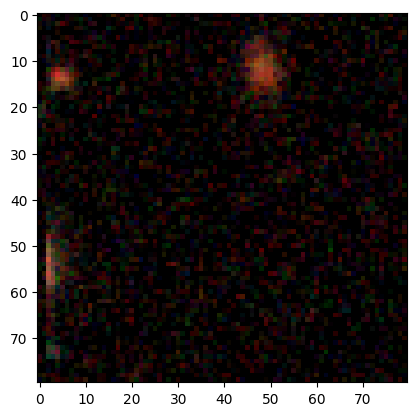

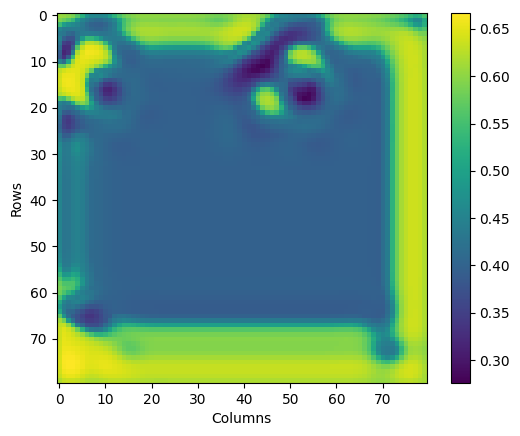

 52%|█████▏    | 199/381 [01:17<01:02,  2.93it/s]

step [200/381], total loss: 4.930e-04, mse loss: 4.639e-04, normal loss: 1.777e-05, smooth loss: 1.134e-05


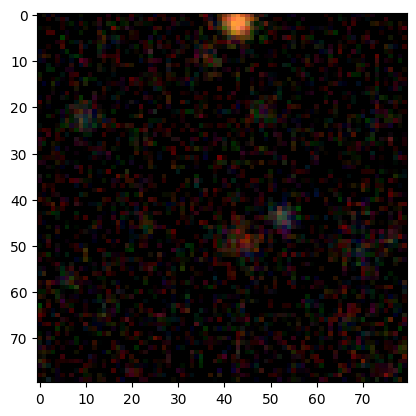

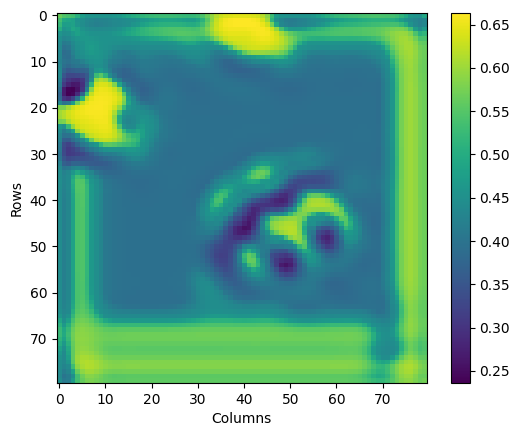

 78%|███████▊  | 299/381 [01:52<00:27,  3.02it/s]

step [300/381], total loss: 4.356e-04, mse loss: 4.192e-04, normal loss: 5.797e-06, smooth loss: 1.058e-05


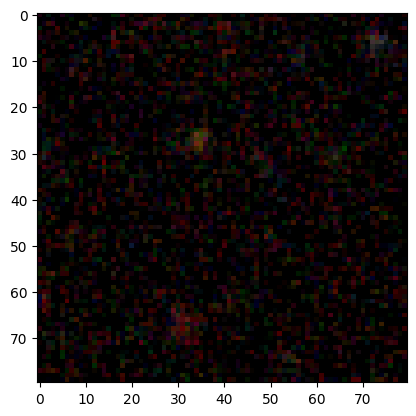

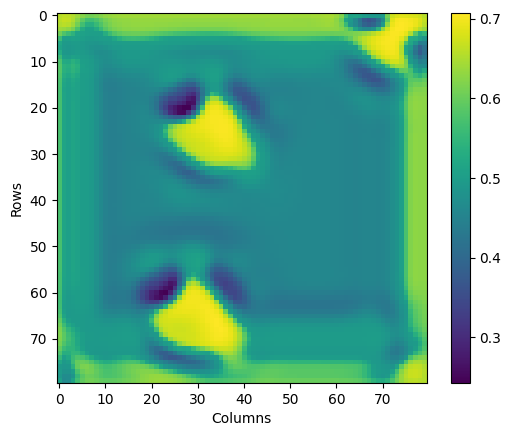

100%|██████████| 381/381 [02:21<00:00,  2.69it/s]


[Epoch: 3]


 26%|██▌       | 99/381 [00:45<02:06,  2.24it/s]

step [100/381], total loss: 4.121e-04, mse loss: 3.975e-04, normal loss: 4.042e-06, smooth loss: 1.064e-05


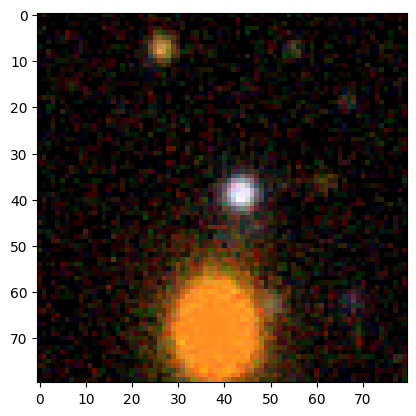

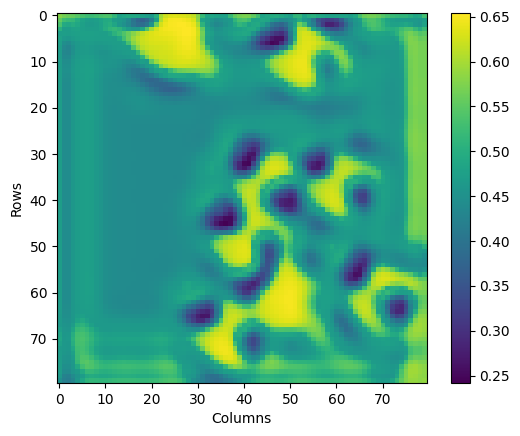

 52%|█████▏    | 199/381 [01:21<01:01,  2.96it/s]

step [200/381], total loss: 2.365e-04, mse loss: 2.210e-04, normal loss: 4.811e-06, smooth loss: 1.062e-05


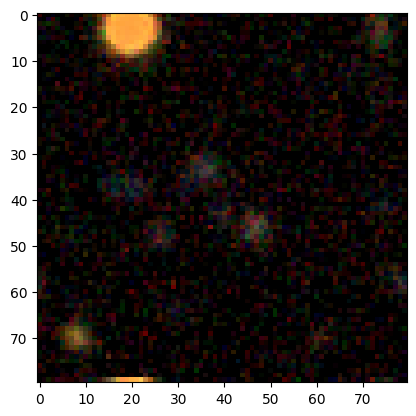

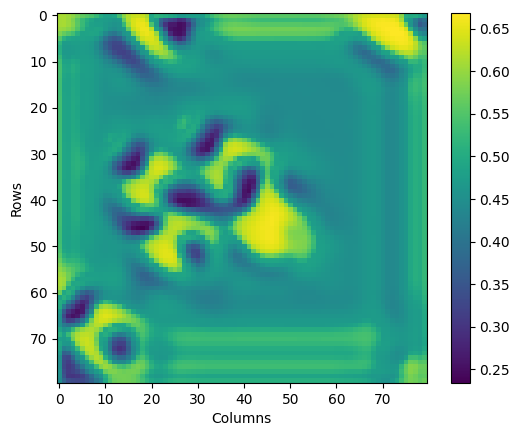

 78%|███████▊  | 299/381 [01:59<00:26,  3.07it/s]

step [300/381], total loss: 3.484e-04, mse loss: 3.304e-04, normal loss: 7.075e-06, smooth loss: 1.096e-05


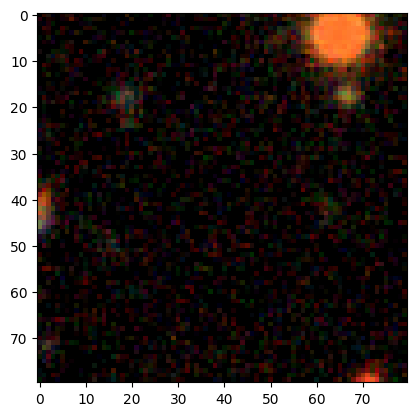

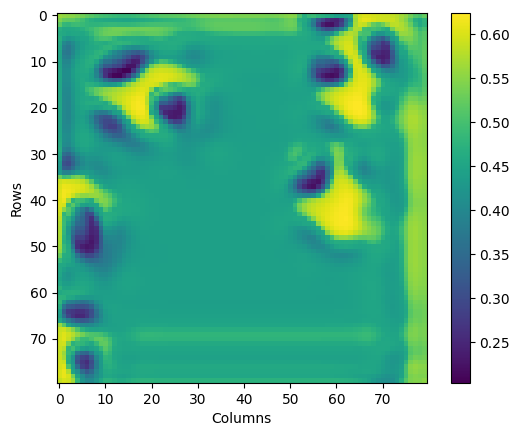

100%|██████████| 381/381 [02:32<00:00,  2.50it/s]


[Epoch: 4]


 26%|██▌       | 99/381 [00:40<01:32,  3.06it/s]

step [100/381], total loss: 1.533e-04, mse loss: 1.406e-04, normal loss: 2.505e-06, smooth loss: 1.024e-05


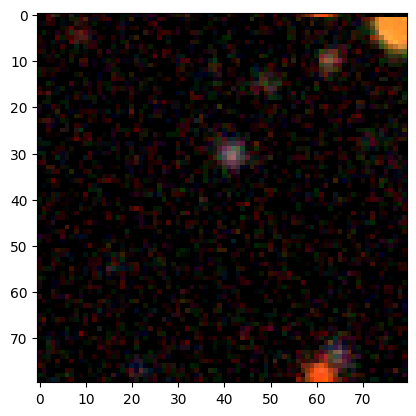

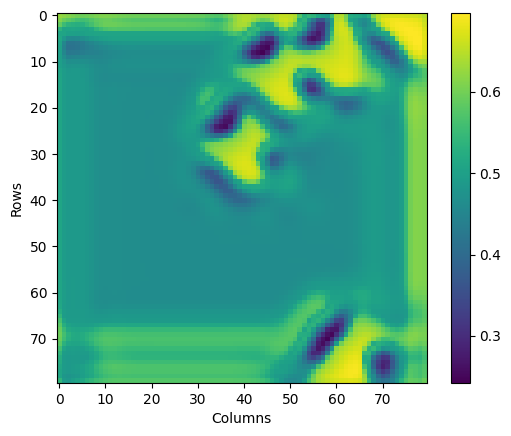

 52%|█████▏    | 199/381 [01:19<00:59,  3.06it/s]

step [200/381], total loss: 4.328e-04, mse loss: 4.203e-04, normal loss: 2.039e-06, smooth loss: 1.047e-05


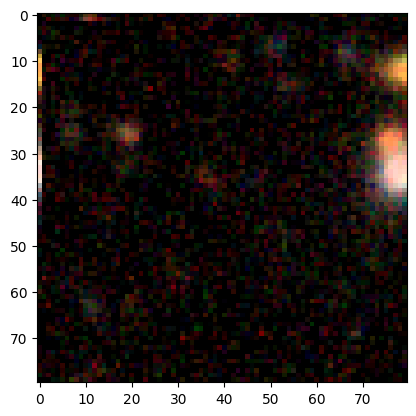

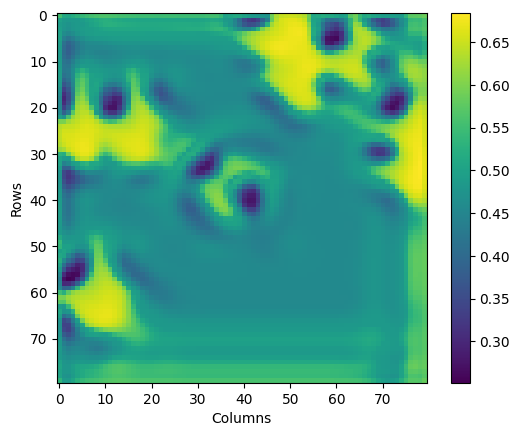

 78%|███████▊  | 299/381 [01:54<00:27,  2.98it/s]

step [300/381], total loss: 2.663e-04, mse loss: 2.542e-04, normal loss: 2.306e-06, smooth loss: 9.797e-06


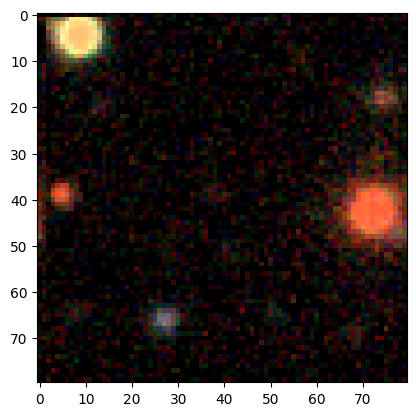

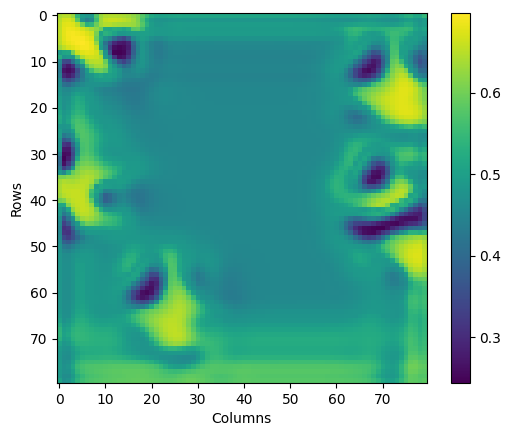

100%|██████████| 381/381 [02:26<00:00,  2.60it/s]


[Epoch: 5]


 26%|██▌       | 99/381 [00:40<01:35,  2.95it/s]

step [100/381], total loss: 3.086e-04, mse loss: 2.964e-04, normal loss: 2.207e-06, smooth loss: 9.987e-06


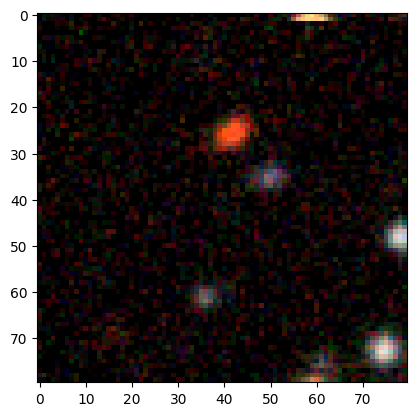

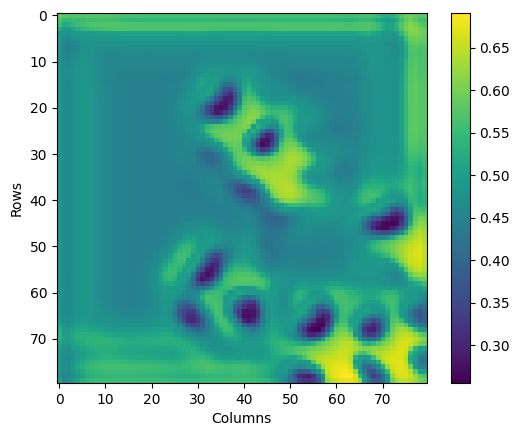

 52%|█████▏    | 199/381 [01:15<01:04,  2.83it/s]

step [200/381], total loss: 1.306e-04, mse loss: 1.186e-04, normal loss: 2.095e-06, smooth loss: 9.873e-06


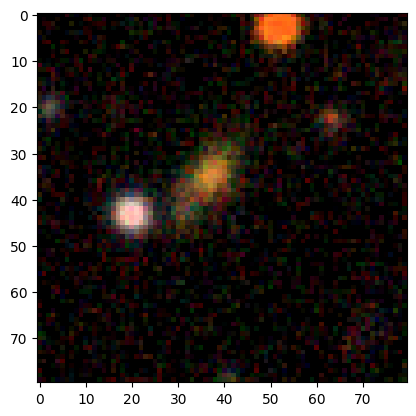

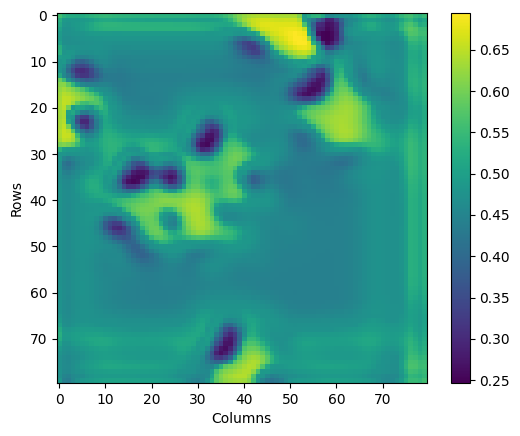

 78%|███████▊  | 299/381 [01:56<00:28,  2.93it/s]

step [300/381], total loss: 2.240e-04, mse loss: 2.126e-04, normal loss: 1.861e-06, smooth loss: 9.523e-06


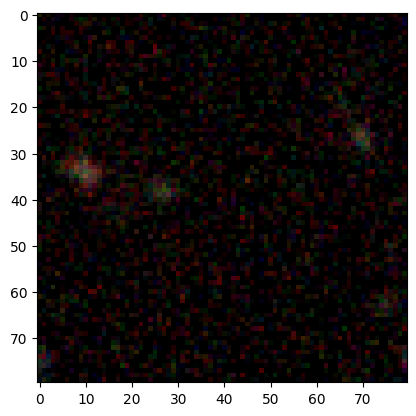

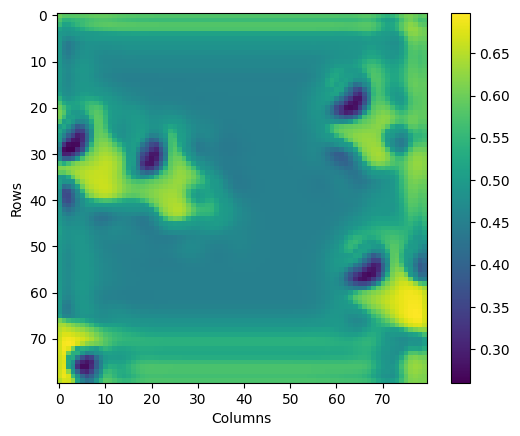

100%|██████████| 381/381 [02:28<00:00,  2.57it/s]


[Epoch: 6]


 26%|██▌       | 99/381 [00:40<01:34,  2.97it/s]

step [100/381], total loss: 3.014e-04, mse loss: 2.890e-04, normal loss: 2.392e-06, smooth loss: 9.999e-06


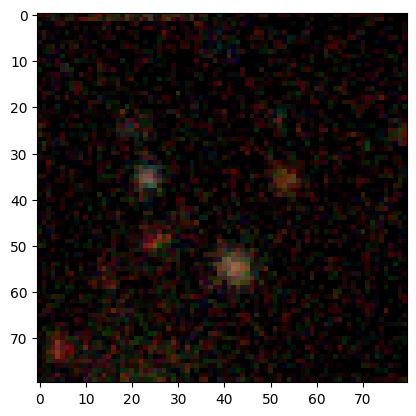

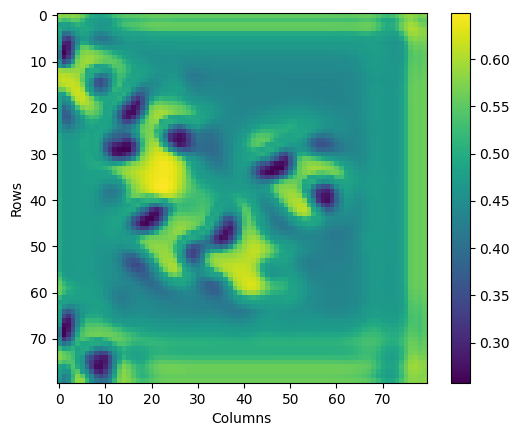

 52%|█████▏    | 199/381 [01:16<01:03,  2.87it/s]

step [200/381], total loss: 2.573e-04, mse loss: 2.458e-04, normal loss: 1.865e-06, smooth loss: 9.707e-06


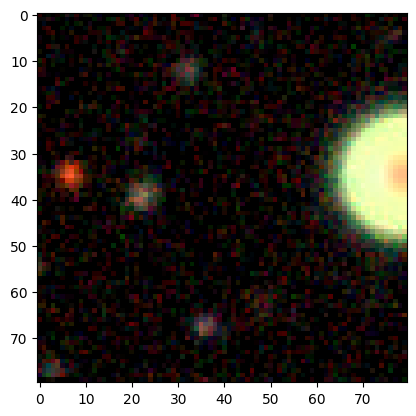

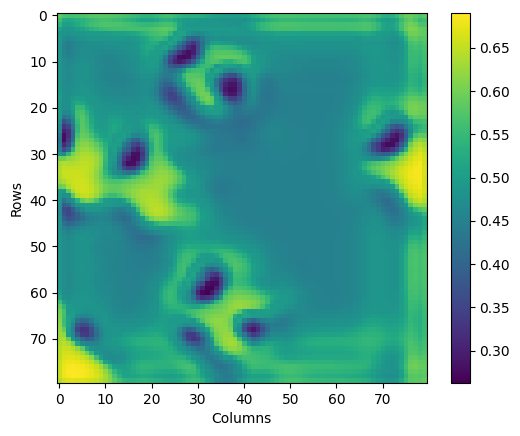

 78%|███████▊  | 299/381 [01:52<00:26,  3.07it/s]

step [300/381], total loss: 1.858e-04, mse loss: 1.738e-04, normal loss: 2.162e-06, smooth loss: 9.843e-06


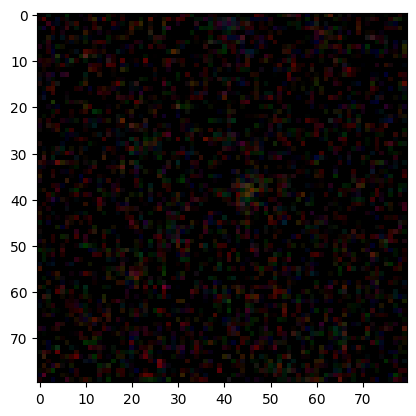

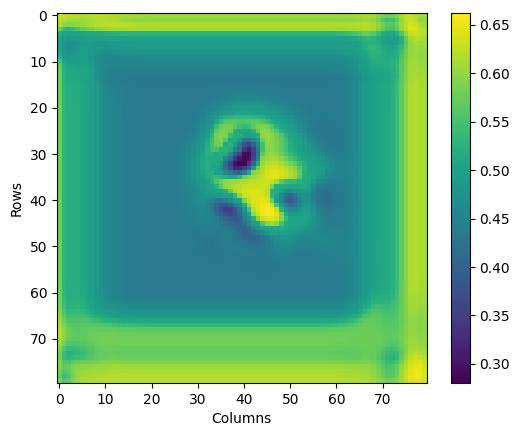

100%|██████████| 381/381 [02:21<00:00,  2.69it/s]


[Epoch: 7]


 26%|██▌       | 99/381 [00:41<01:35,  2.96it/s]

step [100/381], total loss: 2.706e-04, mse loss: 2.583e-04, normal loss: 2.479e-06, smooth loss: 9.835e-06


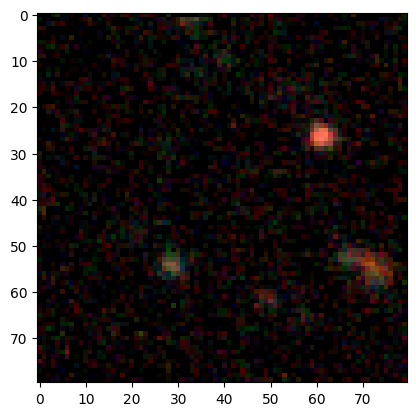

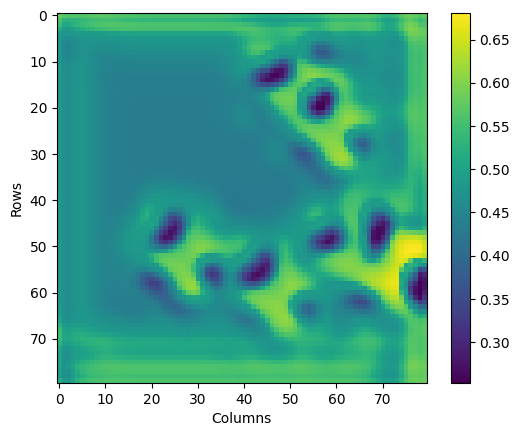

 52%|█████▏    | 199/381 [01:15<01:01,  2.98it/s]

step [200/381], total loss: 1.380e-04, mse loss: 1.258e-04, normal loss: 2.384e-06, smooth loss: 9.815e-06


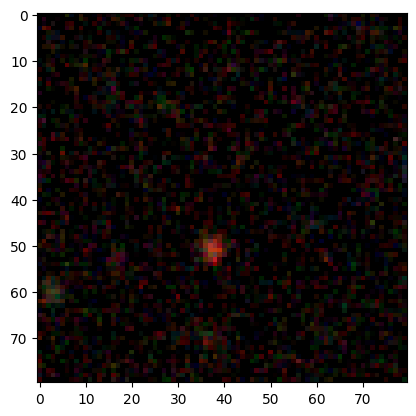

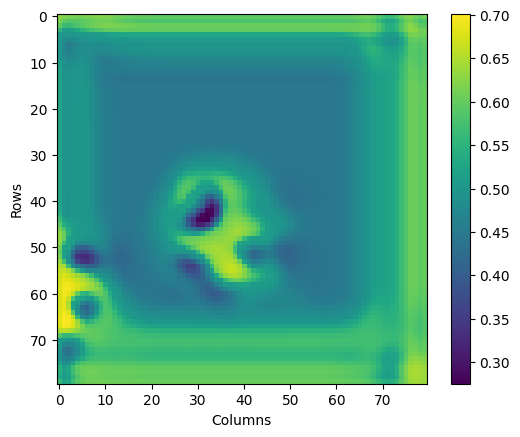

 78%|███████▊  | 299/381 [01:54<00:48,  1.69it/s]

step [300/381], total loss: 3.096e-04, mse loss: 2.970e-04, normal loss: 2.429e-06, smooth loss: 1.016e-05


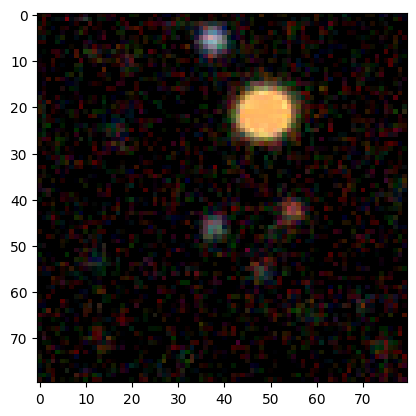

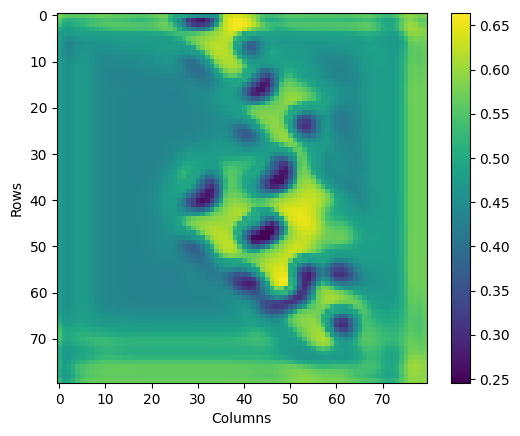

100%|██████████| 381/381 [02:23<00:00,  2.66it/s]


[Epoch: 8]


 26%|██▌       | 99/381 [00:44<01:32,  3.06it/s]

step [100/381], total loss: 4.391e-04, mse loss: 4.260e-04, normal loss: 2.739e-06, smooth loss: 1.042e-05


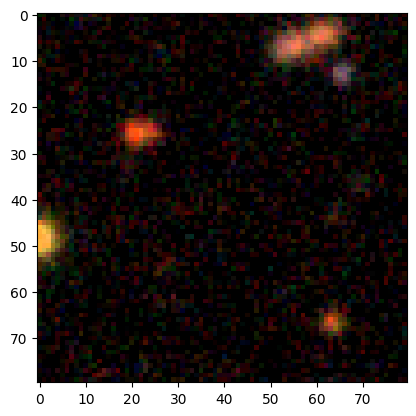

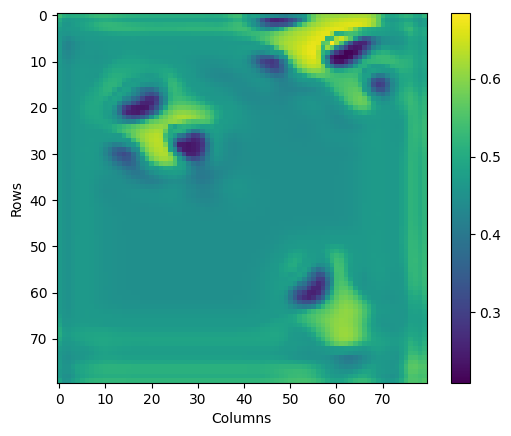

 52%|█████▏    | 199/381 [01:21<01:03,  2.88it/s]

step [200/381], total loss: 2.355e-04, mse loss: 2.227e-04, normal loss: 2.716e-06, smooth loss: 1.005e-05


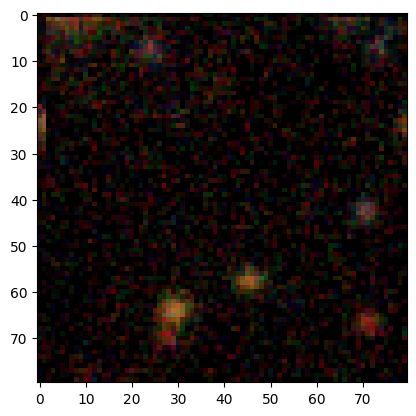

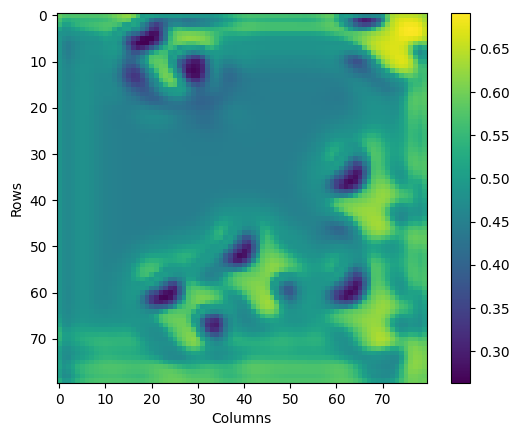

 78%|███████▊  | 299/381 [01:55<00:27,  2.95it/s]

step [300/381], total loss: 2.247e-04, mse loss: 2.119e-04, normal loss: 2.475e-06, smooth loss: 1.037e-05


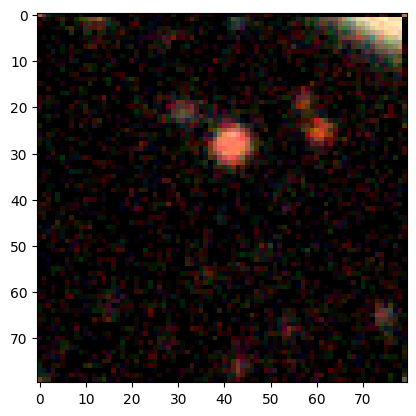

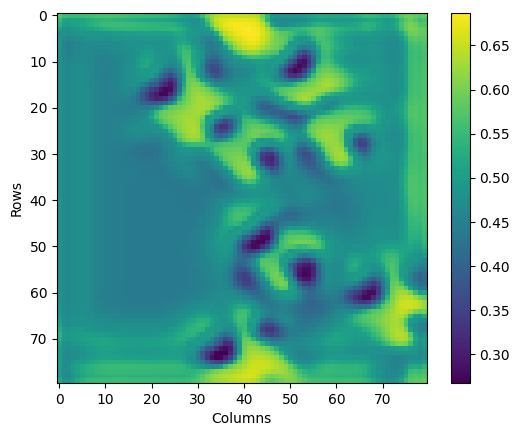

100%|██████████| 381/381 [02:24<00:00,  2.64it/s]


[Epoch: 9]


 26%|██▌       | 99/381 [00:42<01:34,  3.00it/s]

step [100/381], total loss: 3.214e-04, mse loss: 3.084e-04, normal loss: 2.534e-06, smooth loss: 1.048e-05


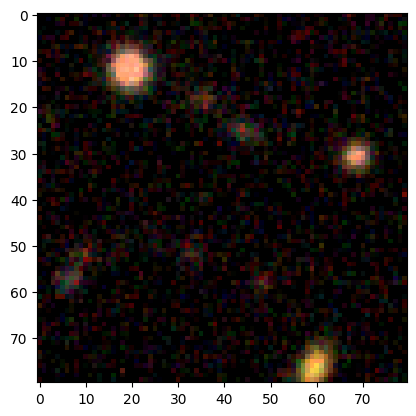

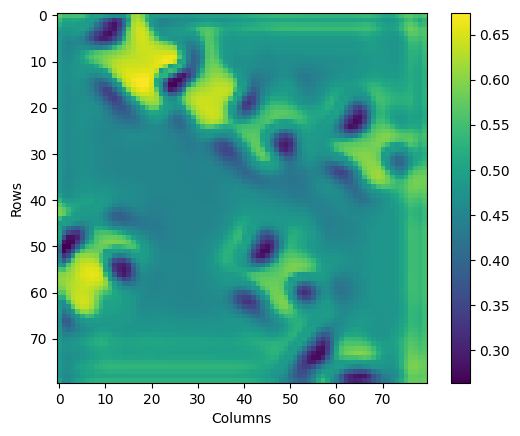

 52%|█████▏    | 199/381 [01:17<01:01,  2.95it/s]

step [200/381], total loss: 2.244e-04, mse loss: 2.119e-04, normal loss: 2.382e-06, smooth loss: 1.015e-05


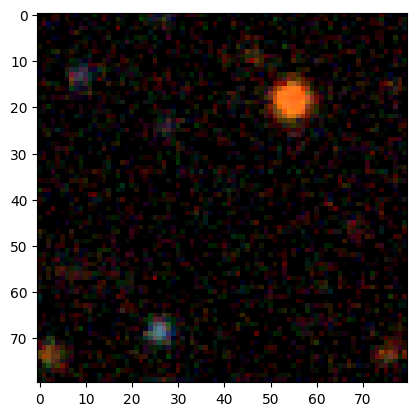

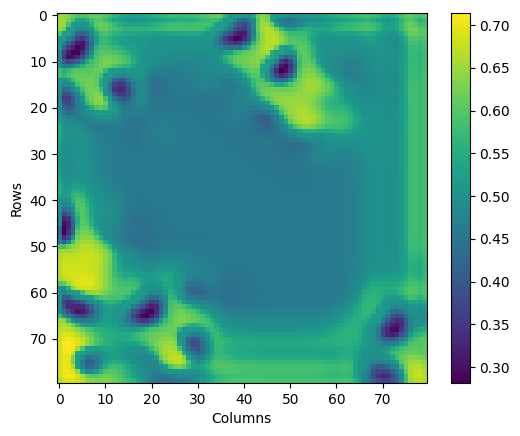

 78%|███████▊  | 299/381 [01:54<00:26,  3.07it/s]

step [300/381], total loss: 1.703e-04, mse loss: 1.585e-04, normal loss: 2.164e-06, smooth loss: 9.696e-06


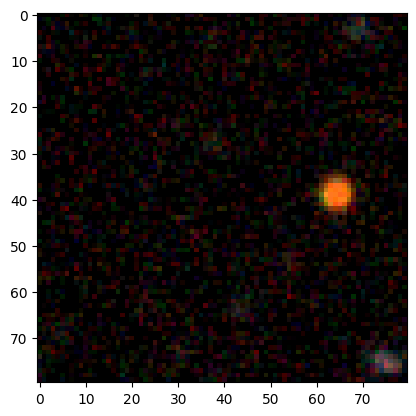

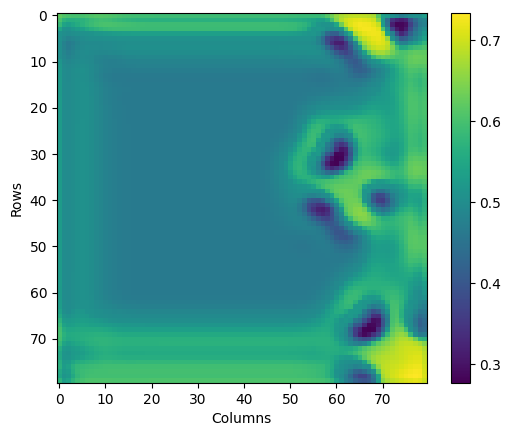

100%|██████████| 381/381 [02:26<00:00,  2.60it/s]


In [14]:
encoder.train()
decoder.train()

total_batch = len(dc2_train_dataloader)
epoch = 10
for e in range(epoch):
    print(f"[Epoch: {e}]")
    i = 0
    dc2_train_dataloader = dc2.train_dataloader()
    for batch in tqdm.tqdm(dc2_train_dataloader):
        batch = move_data_to_device(batch, device=device)
        target_cat = TileCatalog(batch["tile_catalog"])
        target_cat1 = target_cat.get_brightest_sources_per_tile(
            band=2, exclude_num=0
        )
        encoded_catalog_tensor = catalog_parser.encode(target_cat1).permute([0, 3, 1, 2])  # (b, k, h, w)
        image_mask = generate_mask_by_bbox_hw(target_cat1)
    
        optimizer.zero_grad()
        encoder_pred = encoder(encoded_catalog_tensor)
        masked_encoder_pred = encoder_pred * (~image_mask.unsqueeze(1))
        masked_encoder_pred = F.dropout(masked_encoder_pred, p=0.5)
        masked_encoder_pred = masked_encoder_pred.clamp(max=1.5)
        recovered_target = decoder(masked_encoder_pred)
        mse_loss = ((recovered_target - encoded_catalog_tensor) ** 2).mean()
        normal_loss = 1e-3 * normal_distribution_penalty(encoder_pred)
        smooth_loss = 1e-4 * smooth_loss_func(encoder_pred)
        loss = mse_loss + normal_loss + smooth_loss
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"step [{i + 1}/{total_batch}], total loss: {loss.item():.3e}, mse loss: {mse_loss.item():.3e}, normal loss: {normal_loss.item():.3e}, smooth loss: {smooth_loss.item():.3e}")
            
            plt.imshow(create_rgb(batch["images"][0].cpu()))
            plt.show()
            
            plt.imshow(encoder_pred[0].detach().mean(dim=0).cpu().numpy(), 
                       cmap="viridis", interpolation="nearest")
            plt.colorbar()
            plt.xlabel("Columns")
            plt.ylabel("Rows")
            plt.show()
        i += 1
    scheduler.step()
    GlobalEnv.current_encoder_epoch += 1

### Test encoder and decoder

In [15]:
matcher = CatalogMatcher(dist_slack=1.0)
f1_metric = DetectionPerformance().to(device=device)
dc2_val_dataloader = dc2.val_dataloader()

In [16]:
encoder.eval()
decoder.eval()
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_tile_cat = TileCatalog(batch["tile_catalog"])
    target_tile_cat = target_tile_cat.get_brightest_sources_per_tile(band=2,  exclude_num=0)
    target_full_cat = target_tile_cat.to_full_catalog(tile_slen)

    encoded_catalog_tensor = catalog_parser.encode(target_tile_cat).permute([0, 3, 1, 2])  # (b, k, h, w)
    image_mask = generate_mask_by_bbox_hw(target_tile_cat)
    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor)
        masked_encoder_pred = encoder_pred * (~image_mask.unsqueeze(1))
        masked_encoder_pred = F.dropout(masked_encoder_pred, p=0.5)
        masked_encoder_pred = masked_encoder_pred.clamp(max=1.5)
        recovered_target = decoder(masked_encoder_pred)
    recovered_target = catalog_parser.clip_tensor(recovered_target.permute([0, 2, 3, 1]))
    recovered_tile_cat = catalog_parser.decode(recovered_target)
    recovered_full_cat = recovered_tile_cat.to_full_catalog(tile_slen)

    matching = matcher.match_catalogs(target_full_cat, recovered_full_cat)
    f1_metric.update(target_full_cat, recovered_full_cat, matching)

100%|██████████| 49/49 [00:28<00:00,  1.71it/s]


In [17]:
for k, v in f1_metric.compute().items():
    print(f"{k}: {v}")

detection_precision: 0.9893780946731567
detection_recall: 0.9845232367515564
detection_f1: 0.9869447350502014
n_true_sources: 153456.0
n_est_sources: 152703.0


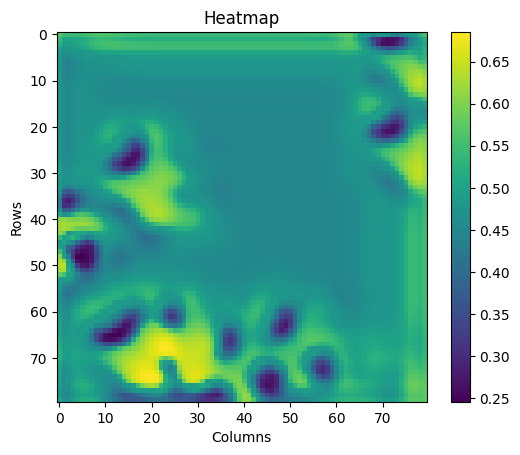

In [18]:
plt.imshow(encoder_pred[3].mean(dim=0).cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

### Train a new decoder without image weights

In [19]:
del decoder

In [20]:
new_decoder = CatalogDecoder(target_ch, hidden_dim=32 // 4)
new_decoder = new_decoder.to(device=device)
new_optimizer = optim.Adam(new_decoder.parameters(), lr=lr, amsgrad=True)

In [21]:
encoder.eval()
new_decoder.train()

total_batch = len(dc2_train_dataloader)
epoch = 3
for _ in range(epoch):
    i = 0
    dc2_train_dataloader = dc2.train_dataloader()
    for batch in tqdm.tqdm(dc2_train_dataloader):
        batch = move_data_to_device(batch, device=device)
        target_cat = TileCatalog(batch["tile_catalog"])
        target_cat1 = target_cat.get_brightest_sources_per_tile(
            band=2, exclude_num=0
        )
        encoded_catalog_tensor = catalog_parser.encode(target_cat1).permute([0, 3, 1, 2])  # (b, k, h, w)
    
        new_optimizer.zero_grad()
        with torch.no_grad():
            encoder_pred = encoder(encoded_catalog_tensor)
        recovered_target = new_decoder(encoder_pred.clamp(max=1.5))
        loss = ((recovered_target - encoded_catalog_tensor) ** 2).mean()
        loss.backward()
        new_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"step [{i + 1}/{total_batch}], loss: {loss.item():.3e}")
        i += 1
    GlobalEnv.current_encoder_epoch += 1

 27%|██▋       | 101/381 [00:42<03:10,  1.47it/s]

step [100/381], loss: 2.174e-02


 52%|█████▏    | 200/381 [01:19<00:35,  5.04it/s]

step [200/381], loss: 1.969e-02


 79%|███████▉  | 301/381 [02:00<00:12,  6.48it/s]

step [300/381], loss: 2.113e-02


 26%|██▌       | 100/381 [00:41<01:41,  2.76it/s]

step [100/381], loss: 2.836e-03


 53%|█████▎    | 201/381 [01:16<01:00,  2.97it/s]

step [200/381], loss: 1.710e-03


 79%|███████▊  | 300/381 [01:51<00:21,  3.76it/s]

step [300/381], loss: 1.628e-03


 26%|██▌       | 100/381 [00:42<04:27,  1.05it/s]

step [100/381], loss: 9.708e-04


 53%|█████▎    | 201/381 [01:17<00:55,  3.25it/s]

step [200/381], loss: 7.268e-04


 79%|███████▊  | 300/381 [01:51<00:16,  4.92it/s]

step [300/381], loss: 6.621e-04


100%|██████████| 381/381 [02:24<00:00,  2.64it/s]


### Test this new decoder

In [22]:
matcher = CatalogMatcher(dist_slack=1.0)
f1_metric = DetectionPerformance().to(device=device)
dc2_val_dataloader = dc2.val_dataloader()

In [23]:
encoder.eval()
new_decoder.eval()
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_tile_cat = TileCatalog(batch["tile_catalog"])
    target_tile_cat = target_tile_cat.get_brightest_sources_per_tile(band=2,  exclude_num=0)
    target_full_cat = target_tile_cat.to_full_catalog(tile_slen)

    encoded_catalog_tensor = catalog_parser.encode(target_tile_cat).permute([0, 3, 1, 2])  # (b, k, h, w)
    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor)
        recovered_target = new_decoder(encoder_pred.clamp(max=1.5))
    recovered_target = catalog_parser.clip_tensor(recovered_target.permute([0, 2, 3, 1]))
    recovered_tile_cat = catalog_parser.decode(recovered_target)
    recovered_full_cat = recovered_tile_cat.to_full_catalog(tile_slen)

    matching = matcher.match_catalogs(target_full_cat, recovered_full_cat)
    f1_metric.update(target_full_cat, recovered_full_cat, matching)

100%|██████████| 49/49 [00:28<00:00,  1.71it/s]


In [24]:
for k, v in f1_metric.compute().items():
    print(f"{k}: {v}")

detection_precision: 0.9009283781051636
detection_recall: 0.8986093997955322
detection_f1: 0.8997673988342285
n_true_sources: 153456.0
n_est_sources: 153061.0


In [25]:
torch.save(encoder.state_dict(), "encoder.pt")
torch.save(new_decoder.state_dict(), "decoder.pt")

### Plotting

In [26]:
image_index = 6

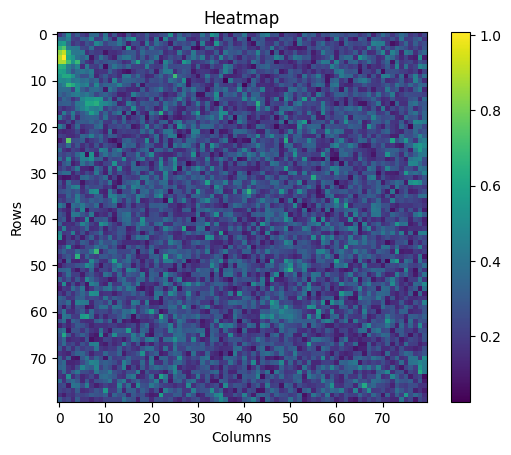

In [27]:
plt.imshow((batch["images"][image_index].norm(dim=0, p=2) + 1).log().cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [28]:
encoder_pred.max(), encoder_pred.min()

(tensor(1.6947, device='cuda:1'), tensor(0., device='cuda:1'))

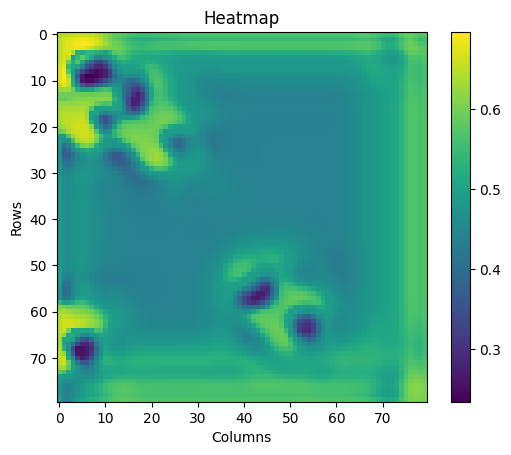

In [29]:
plt.imshow(encoder_pred[image_index].mean(dim=0).cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

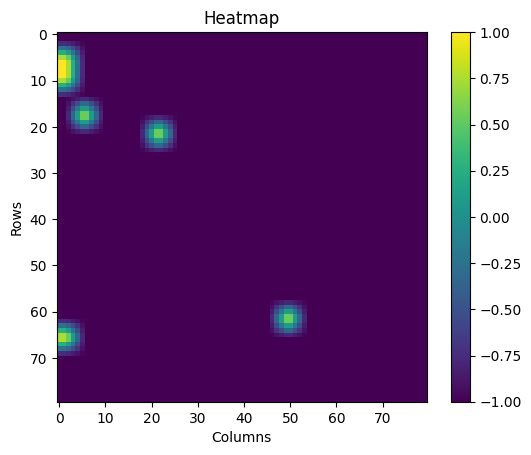

In [30]:
upsampled_cat_tensor = F.interpolate(encoded_catalog_tensor, scale_factor=4, mode="bilinear")
plt.imshow(upsampled_cat_tensor[image_index, 0].cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

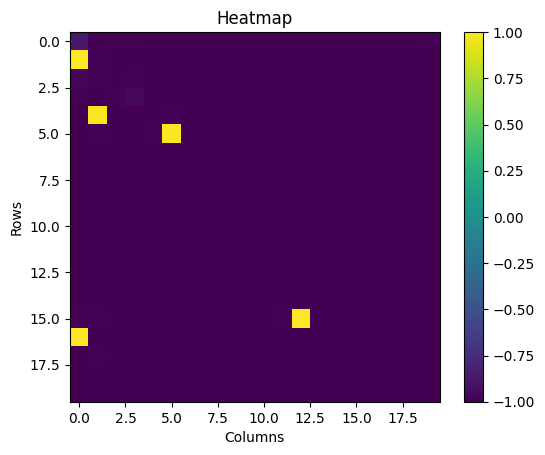

In [31]:
plt.imshow(recovered_target.permute([0, 3, 1, 2])[image_index, 0].cpu().numpy(), 
           cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

### Get min and max

In [32]:
encoder.eval()

dc2_train_dataloader = dc2.train_dataloader()
encoder_pred_max = -torch.inf
encoder_pred_min = torch.inf
for batch in tqdm.tqdm(dc2_train_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_cat = TileCatalog(batch["tile_catalog"])
    target_cat1 = target_cat.get_brightest_sources_per_tile(
        band=2, exclude_num=0
    )
    encoded_catalog_tensor = catalog_parser.encode(target_cat1).permute([0, 3, 1, 2])  # (b, k, h, w)

    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor)
    if encoder_pred.max() > encoder_pred_max:
        encoder_pred_max = encoder_pred.max()
    if encoder_pred.min() < encoder_pred_min:
        encoder_pred_min = encoder_pred.min()

dc2_val_dataloader = dc2.val_dataloader()
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_cat = TileCatalog(batch["tile_catalog"])
    target_cat1 = target_cat.get_brightest_sources_per_tile(
        band=2, exclude_num=0
    )
    encoded_catalog_tensor = catalog_parser.encode(target_cat1).permute([0, 3, 1, 2])  # (b, k, h, w)

    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor)

    if encoder_pred.max() > encoder_pred_max:
        encoder_pred_max = encoder_pred.max()
    if encoder_pred.min() < encoder_pred_min:
        encoder_pred_min = encoder_pred.min()

100%|██████████| 49/49 [00:11<00:00,  4.21it/s]


In [33]:
encoder_pred_min, encoder_pred_max

(tensor(0., device='cuda:1'), tensor(2.0976, device='cuda:1'))